# TRANSFORMACIÓN DE DATOS

## IMPORTAR PAQUETES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

1.- Sustituir la ruta del proyecto.

In [3]:
ruta_proyecto = 'E:/alex/03_MACHINE_LEARNING/08_CASOS//03_SCORING RIESGOS'

2.- Nombrar los ficheros de datos.

In [4]:
nombre_cat = 'cat_resultado_eda.pickle'
nombre_num = 'num_resultado_eda.pickle'

3.- Cargar los datos.

In [5]:
cat = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_cat)
num = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_num)

Recordamos lo que habíamos identificado en fases anteriores y lo organizamos por tipo de acción.

Modificar con pandas/numpy:

* Crear la target a partir de estado
* Discretizar num_meses_desde_ult_retraso
* En vivienda juntar NONE y OTHER
* En finalidad juntar renewable_energy, educational y vacation en 'otros'

Modificar con scikit learn:

* La variable descripcion podríamos trabajarla con un TF-IDF Vectorizer
* Convertir num_derogatorios a binaria

## CREACIÓN DE VARIABLES Y TRANSFORMACIONES CON PANDAS

### Target para el modelo PD

Crear la target a partir de estado

In [6]:
cat.estado.value_counts()

Fully Paid                                             66083
Current                                                54128
Charged Off                                            16533
Late (31-120 days)                                      1343
In Grace Period                                          536
Late (16-30 days)                                        269
Does not meet the credit policy. Status:Fully Paid       125
Does not meet the credit policy. Status:Charged Off       55
Default                                                    2
Name: estado, dtype: int64

In [7]:
cat['target_pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,target_pd
id_cliente,,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,desconocido,debt_consolidation,36 months,Current,0
4798121,"Target Promotions and Marketing,Inc",10+ years,Not Verified,D,RENT,desconocido,debt_consolidation,36 months,Charged Off,1
46641215,Banker,5 years,Verified,A,RENT,desconocido,debt_consolidation,36 months,Fully Paid,0
87998444,executive director,9 years,Source Verified,B,MORTGAGE,desconocido,credit_card,60 months,Current,0
132883631,Subsea Technician,7 years,Source Verified,B,MORTGAGE,desconocido,debt_consolidation,36 months,Fully Paid,0
...,...,...,...,...,...,...,...,...,...,...
999338,T. Rowe Price,4 years,Verified,B,RENT,Borrower added on 11/01/11 > Looking to use ...,debt_consolidation,60 months,Fully Paid,0
73222117,Executive Assistant,10+ years,Verified,B,RENT,desconocido,debt_consolidation,36 months,Fully Paid,0
51876926,Office Manager,10+ years,Not Verified,C,MORTGAGE,desconocido,debt_consolidation,36 months,Fully Paid,0


In [8]:
cat.drop(columns='estado',inplace=True)

### Target para el modelo EAD

Será el porcentaje del principal que no había sido amortizado.

Por tanto: pendiente / principal

Primero tenemos que construir el pendiente como el principal menos el amortizado.

In [9]:
num['pendiente'] = num.principal - num.imp_amortizado
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente
id_cliente,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999338,55000.0,29.26,0.0,7.0,0.0,66.4,0.0,0.0,0.0,20000.0,12.69,451.90,20000.00,0.00,0.00
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00


In [10]:
num['target_ead'] = num.pendiente / num.principal
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead
id_cliente,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999338,55000.0,29.26,0.0,7.0,0.0,66.4,0.0,0.0,0.0,20000.0,12.69,451.90,20000.00,0.00,0.00,0.000000
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00,0.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000


### Target para el modelo LGD

Será el porcentaje del pendiente que NO se recupera en caso de impago.

Por tanto: 1 - (imp_recuperado / pendiente)

In [11]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139074 entries, 137387967 to 94394801
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ingresos                     139074 non-null  float64
 1   dti                          139074 non-null  float64
 2   num_hipotecas                139074 non-null  float64
 3   num_lineas_credito           139074 non-null  float64
 4   porc_tarjetas_75p            139074 non-null  float64
 5   porc_uso_revolving           139074 non-null  float64
 6   num_cancelaciones_12meses    139074 non-null  float64
 7   num_derogatorios             139074 non-null  float64
 8   num_meses_desde_ult_retraso  139074 non-null  float64
 9   principal                    139074 non-null  float64
 10  tipo_interes                 139074 non-null  float64
 11  imp_cuota                    139074 non-null  float64
 12  imp_amortizado               139074 non-null  fl

In [44]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.pendiente)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,NaN
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999338,55000.0,29.26,0.0,7.0,0.0,66.4,0.0,0.0,0.0,20000.0,12.69,451.90,20000.00,0.00,0.00,0.000000,NaN
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00,0.000000,NaN
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000,NaN


Los nulos se producen cuando el pendiente es cero. Por tanto podemos imputarlos por ceros.

In [45]:
num['target_lgd'].fillna(0,inplace=True)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999338,55000.0,29.26,0.0,7.0,0.0,66.4,0.0,0.0,0.0,20000.0,12.69,451.90,20000.00,0.00,0.00,0.000000,0.000000
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00,0.000000,0.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000,0.000000


Comprobamos las targets creadas.

In [46]:
cat['target_pd'].mean()

0.11928901160533241

In [47]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139074.0,0.338083,0.369154,-0.000003,0.0,0.132827,0.725729,1.0
target_lgd,139074.0,0.509590,0.490280,-0.275957,0.0,0.851636,1.000000,1.0


Limitamos para garantizar que siempre estén entre 0 y 1

In [48]:
num.target_ead = np.where(num.target_ead < 0, 0, num.target_ead)
num.target_ead = np.where(num.target_ead > 1, 1, num.target_ead)
num.target_lgd = np.where(num.target_lgd < 0, 0, num.target_lgd)
num.target_lgd = np.where(num.target_lgd > 1, 1, num.target_lgd)

In [49]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139074.0,0.338083,0.369154,0.0,0.0,0.132827,0.725729,1.0
target_lgd,139074.0,0.509616,0.490248,0.0,0.0,0.851636,1.000000,1.0


### Resto de variables

num_meses_desde_ult_retraso

Vamos a comenzar revisando la relación con la target_pd

In [50]:
temp = num[['num_meses_desde_ult_retraso']].copy()

In [51]:
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
temp['target'] = cat['target_pd']

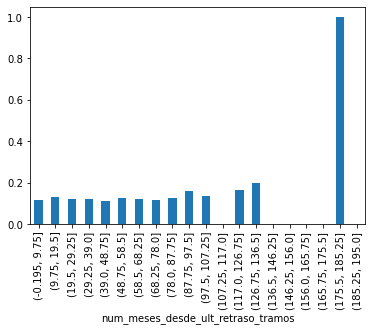

In [52]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

La distribución de la target en esta variable no nos genera confianza, así que la descartamos.

In [53]:
num.drop(columns='num_meses_desde_ult_retraso',inplace=True)

En vivienda juntar ANY, NONE y OTHER

In [54]:
cat.vivienda.value_counts()

MORTGAGE    67878
RENT        55506
OWN         15622
ANY            56
OTHER          11
NONE            1
Name: vivienda, dtype: int64

In [55]:
cat.vivienda = cat.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')

In [56]:
cat.vivienda.value_counts()

MORTGAGE    67946
RENT        55506
OWN         15622
Name: vivienda, dtype: int64

En finalidad juntar renewable_energy, educational y wedding en 'otros'

In [57]:
cat.finalidad.value_counts()

debt_consolidation    78904
credit_card           31477
home_improvement       9106
other                  8566
major_purchase         3167
medical                1734
small_business         1617
car                    1385
vacation                989
moving                  978
house                   906
wedding                 133
renewable_energy         87
educational              25
Name: finalidad, dtype: int64

In [58]:
cat.finalidad = cat.finalidad.replace(['wedding','educational','renewable_energy'],'otros')

In [59]:
cat.finalidad.value_counts()

debt_consolidation    78904
credit_card           31477
home_improvement       9106
other                  8566
major_purchase         3167
medical                1734
small_business         1617
car                    1385
vacation                989
moving                  978
house                   906
otros                   245
Name: finalidad, dtype: int64

## TRANSFORMACIÓN DE CATEGÓRICAS

### One Hot Encoding

#### Variables a aplicar OHE

In [60]:
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']

#### Instanciar

In [61]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

#### Entrenar y aplicar

In [62]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

#### Guardar como dataframe

In [63]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

#### Variables a aplicar OE

In [64]:
var_oe = ['antigüedad_empleo','rating']

#### Orden de los valores de las variables

In [65]:
#Orden de la primera variable
orden_antigüedad_empleo = ['desconocido','< 1 year','1 year','2 years','3 years','4 years',
                           '5 years','6 years','7 years','8 years','9 years','10+ years']

#Orden de la segunda variable
orden_rating = ['A','B','C','D','E','F','G']

#### Instanciar

In [67]:
oe = OrdinalEncoder(categories = [orden_antigüedad_empleo,orden_rating],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#### Entrenar y aplicar

In [68]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Guardar como dataframe

In [69]:
#Añadir sufijos a los nombres
nombres_oe = [variable + '_oe' for variable in var_oe]

#Guardar como dataframe
cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

### Fechas y textos

Cargamos stopwords y limpiamos

In [70]:
stop = pd.read_csv(ruta_proyecto + '/01_Documentos/stop_words_english.txt',names = ['termino'])

def quitar_tildes(palabra):
    #Definimos la versión con tildes y símbolos y la sin
    con = 'áéíóúüñÁÉÍÓÚÜÑ'
    sin = 'aeiouunAEIOUUN'
    #Creamos un traductor
    traductor = str.maketrans(con,sin)
    #Aplicamos el traductor y devolvemos la palabra limpia
    return(palabra.translate(traductor))

stop['limpias'] = stop.termino.transform(quitar_tildes)

Aplicamos tf-idf.

In [71]:
#Instanciamos
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stop.limpias.to_list(),
                     max_df = 0.7,
                     min_df = 50,
                     ngram_range = (1,3),
                     max_features = 50)

#Entrenamos y aplicamos
descripcion = tfidf.fit_transform(cat.descripcion)

C:\Users\Alex\miniconda3\envs\proyecto1\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [72]:
tfidf.vocabulary_

{'borrower': 15,
 '08': 7,
 '01': 0,
 '12': 11,
 'br': 22,
 '02': 1,
 'loan': 38,
 'borrower 08': 20,
 'br br': 24,
 'br borrower': 23,
 'br br borrower': 25,
 '07': 6,
 '13': 12,
 'consolidate': 29,
 'credit': 31,
 'card': 26,
 'years': 49,
 'borrower 07': 19,
 'credit card': 32,
 'bills': 14,
 'pay': 42,
 'payments': 46,
 'cards': 28,
 'monthly': 41,
 'paying': 44,
 'debt': 35,
 'rate': 47,
 'credit cards': 34,
 'borrower 12': 21,
 '11': 10,
 '09': 8,
 'job': 37,
 'time': 48,
 '10': 9,
 'pay credit': 43,
 '03': 2,
 '14': 13,
 'borrower 01': 16,
 '06': 5,
 'high': 36,
 'money': 39,
 'payment': 45,
 '05': 4,
 'month': 40,
 'borrower 02': 17,
 'consolidation': 30,
 'borrower 03': 18,
 'card debt': 27,
 'credit card debt': 33,
 '04': 3}

No parece que estos términos puedan generar información adicional a lo que tenemos, así que no incluiremos esta variable en los modelos.

## TRANSFORMACIÓN DE NUMÉRICAS

### Binarizar variables

#### Variables a binarizar

In [73]:
var_bin = ['num_derogatorios']

#### Instanciar

In [74]:
bin = Binarizer(threshold=0)

#### Entrenar y aplicar

In [75]:
num_bin = bin.fit_transform(num[var_bin])

#### Guardar como dataframe

In [76]:
#Añadir sufijos a los nombres
nombres_bin = [variable + '_bin' for variable in var_bin]

#Guardar como dataframe
num_bin = pd.DataFrame(num_bin,columns = nombres_bin)

## REESCALAR VARIABLES

### Con Min-Max

Unificar los datasets a reescalar.

In [80]:
num_escalar = num[['ingresos',
                  'dti',
                  'num_lineas_credito',
                  'porc_uso_revolving',
                  'principal',
                  'tipo_interes',
                  'imp_cuota']].reset_index(drop=True)

In [81]:
df_res = pd.concat([cat_oe,num_escalar], axis=1)

#### Variables a reescalar con Min-Max

In [82]:
var_mms = df_res.columns

#### Instanciar

In [83]:
mms = MinMaxScaler()

#### Entrenar y aplicar

In [84]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Guardar como dataframe

In [85]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

## UNIFICAR DATASETS

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de PD

In [86]:
incluir_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de PD

In [87]:
df_pd = pd.concat(incluir_pd, axis = 1)

In [88]:
df_pd.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de EAD

In [89]:
incluir_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_ead']]]

### Unir todos los dataframes en el tablón analítico para el modelo de EAD

In [90]:
df_ead = pd.concat(incluir_ead, axis = 1)

In [91]:
df_ead.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de LGD

In [92]:
incluir_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_lgd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de LGD

In [93]:
df_lgd = pd.concat(incluir_lgd, axis = 1)

In [94]:
df_lgd.set_index('id_cliente',inplace=True)

## GUARDAR DATASETS TRAS TRANSFORMACIÓN DE DATOS

En formato pickle para no perder las modificaciones de metadatos.

In [95]:
#Definir los nombres de los archivos
ruta_df_tablon_pd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_pd.pickle'
ruta_df_tablon_ead = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_ead.pickle'
ruta_df_tablon_lgd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_lgd.pickle'

In [96]:
#Guardar los archivos
df_pd.to_pickle(ruta_df_tablon_pd)
df_ead.to_pickle(ruta_df_tablon_ead)
df_lgd.to_pickle(ruta_df_tablon_lgd)